In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import *
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import anderson
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [109]:
train_df = pd.read_csv("data/train.csv")
features_df = pd.read_csv("data/features.csv")
stores_df = pd.read_csv("data/stores.csv")
test_df = pd.read_csv("data/test.csv")

In [110]:
train_df = (train_df
            .merge(features_df, how='left', indicator='indicator_column')
            .merge(stores_df, how='left'))
train_df.drop(columns=['indicator_column'], axis=1, inplace=True)

In [111]:
train_df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

In [112]:
train_df = train_df.loc[train_df['Weekly_Sales'] > 0] #outliers
# train_df["Date"] = pd.to_datetime(train_df["Date"])
train_df['year'] = pd.DatetimeIndex(train_df['Date']).year # Separating year data.
train_df['month'] = pd.DatetimeIndex(train_df['Date']).month # extract month data

week_df = pd.DatetimeIndex(train_df['Date']).isocalendar()
train_df['week'] = week_df['week'].values

train_df.fillna(0, inplace=True)
train_df['Total_MarkDown'] = train_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].sum(axis=1).astype(float)
# train_df.set_index("Date")

In [113]:
train_df.isna().sum()

Store             0
Dept              0
Date              0
Weekly_Sales      0
IsHoliday         0
Temperature       0
Fuel_Price        0
MarkDown1         0
MarkDown2         0
MarkDown3         0
MarkDown4         0
MarkDown5         0
CPI               0
Unemployment      0
Type              0
Size              0
year              0
month             0
week              0
Total_MarkDown    0
dtype: int64

In [114]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420212 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Store           420212 non-null  int64  
 1   Dept            420212 non-null  int64  
 2   Date            420212 non-null  object 
 3   Weekly_Sales    420212 non-null  float64
 4   IsHoliday       420212 non-null  bool   
 5   Temperature     420212 non-null  float64
 6   Fuel_Price      420212 non-null  float64
 7   MarkDown1       420212 non-null  float64
 8   MarkDown2       420212 non-null  float64
 9   MarkDown3       420212 non-null  float64
 10  MarkDown4       420212 non-null  float64
 11  MarkDown5       420212 non-null  float64
 12  CPI             420212 non-null  float64
 13  Unemployment    420212 non-null  float64
 14  Type            420212 non-null  object 
 15  Size            420212 non-null  int64  
 16  year            420212 non-null  int64  
 17  month     

In [115]:
times_without_markdowns = [train_df['Date'][i] for i in range(40, 91)]
times_with_markdowns = [train_df['Date'][i] for i in range(92, 143)]

In [116]:
print(list(train_df['Date'].unique()))

['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26', '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26', '2010-04-02', '2010-04-09', '2010-04-16', '2010-04-23', '2010-04-30', '2010-05-07', '2010-05-14', '2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11', '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09', '2010-07-16', '2010-07-23', '2010-07-30', '2010-08-06', '2010-08-13', '2010-08-20', '2010-08-27', '2010-09-03', '2010-09-10', '2010-09-17', '2010-09-24', '2010-10-01', '2010-10-08', '2010-10-15', '2010-10-22', '2010-10-29', '2010-11-05', '2010-11-12', '2010-11-19', '2010-11-26', '2010-12-03', '2010-12-10', '2010-12-17', '2010-12-24', '2010-12-31', '2011-01-07', '2011-01-14', '2011-01-21', '2011-01-28', '2011-02-04', '2011-02-11', '2011-02-18', '2011-02-25', '2011-03-04', '2011-03-11', '2011-03-18', '2011-03-25', '2011-04-01', '2011-04-08', '2011-04-15', '2011-04-22', '2011-04-29', '2011-05-06', '2011-05-13', '2011-05-20', '2011-05-27', '2011-06-03', '2011-06-10', '2011

In [117]:
print(list(train_df['Date'].unique()).index('2010-11-12'))
print(list(train_df['Date'].unique()).index('2011-10-28'))

40
90


In [118]:
print(list(train_df['Date'].unique()).index('2011-11-11'))
print(list(train_df['Date'].unique()).index('2012-10-26'))

92
142


In [119]:
train_df.shape

(420212, 20)

In [120]:
train_df['month']

0          2
1          2
2          2
3          2
4          3
          ..
421565     9
421566    10
421567    10
421568    10
421569    10
Name: month, Length: 420212, dtype: int64

# Testing Normality Assumption
###  Kolmogorov–Smirnov test

In [121]:
stat, p = kstest(train_df['Weekly_Sales'], 'norm')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p < alpha:
    print('Sample does not look Gaussian (reject H0)')
else:
    print('Sample looks Gaussian (fail to reject H0)')

Statistics=0.995, p=0.000
Sample does not look Gaussian (reject H0)


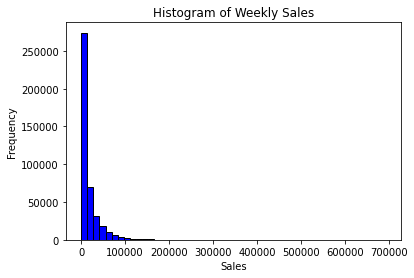

In [122]:
plt.hist(train_df['Weekly_Sales'], bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Weekly Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

### BoxCox transformation

In [123]:
train_df['boxcox_sales'], _ = boxcox(train_df['Weekly_Sales'])

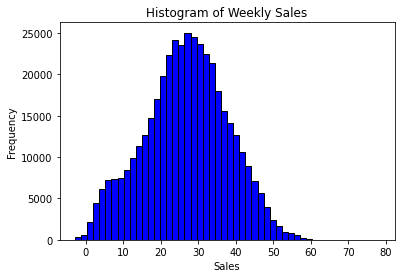

In [124]:
plt.hist(train_df['boxcox_sales'], bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Weekly Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

In [125]:
stat, p = kstest(train_df['boxcox_sales'], 'norm')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.986, p=0.000
Sample does not look Gaussian (reject H0)


# Markdowns 

In [126]:
# Split data into two groups: days with markdowns and days without markdowns
sales_with_markdown = train_df[train_df['Date'].isin(times_with_markdowns)]['Weekly_Sales'] # Nov 11 to Oct 26 [2012]
sales_without_markdown = train_df[train_df['Date'].isin(times_without_markdowns)]['Weekly_Sales'] # Nov 12 to Oct 28 [2011]
train_df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'year', 'month',
       'week', 'Total_MarkDown', 'boxcox_sales'],
      dtype='object')

In [127]:
print(sales_with_markdown.shape)
print(sales_without_markdown.shape)

(150929,)
(149535,)


In [128]:
print(sales_with_markdown.mean())
print(sales_with_markdown.median())

16231.116040721136
7585.62


In [129]:
print(sales_without_markdown.mean())
print(sales_without_markdown.median())

16021.836361788208
7596.61


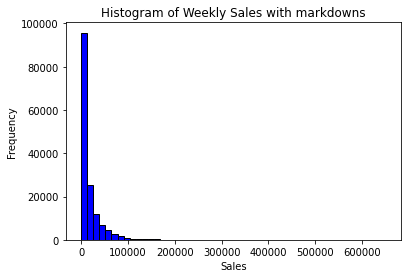

In [130]:
plt.hist(sales_with_markdown, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Weekly Sales with markdowns')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

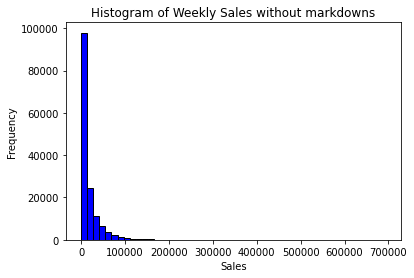

In [131]:
plt.hist(sales_without_markdown, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Weekly Sales without markdowns')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Two-Sample Kolmogorov-Smirnov (KS)
The Two-Sample Kolmogorov-Smirnov (KS) Test is a non-parametric test used to determine if two independent samples come from the same continuous distribution. Unlike the t-test, which compares sample means, the KS test compares the entire distribution of data for both samples.

For the Two-Sample KS Test to be valid, the following assumptions should be considered:

- Independence: Observations within each sample and between the two samples must be independent.

- Continuous Distribution: The test is most suitable for continuous distributions. If used on discrete distributions, the calculated probabilities may be higher than the actual significance levels.

- Random Sampling: The data for both samples should be randomly drawn from their respective populations.

- Identical Distributions (under null hypothesis): Under the null hypothesis, it is assumed that both samples come from the same distribution. The alternative hypothesis posits that they come from different distributions.

In [132]:
if ks_2samp(sales_with_markdown, sales_without_markdown).pvalue < alpha:
    print(" the two samples do not come from the same distribution.")

 the two samples do not come from the same distribution.


- The two samples do have similar shapes: and that's an assumption of Mann Whitney U test

# Homoscedasticity (Equal Variances)

## Levene's Test
Levene's Test is used to test the assumption of equal variances among two or more groups. Equal variances across samples is called homoscedasticity or homogeneity of variances. This test is an alternative to the Bartlett's test, offering more robustness when the assumptions of normality are not met.

For the Levene's Test to provide valid results, it's crucial to meet the following assumptions:

- Independence: Observations within each group and among different groups must be independent.

- Random Sampling: The data for all groups should be obtained through a random sampling method from their respective populations.

- Measurement Level: The dependent variable should be at least interval or ratio in scale, which means it should be numeric (continuous or discrete).

- Normally Distributed (with a caveat): While the test is more robust to violations of this assumption compared to, say, Bartlett's test, it's still generally expected that the data comes from a normally distributed population. However, the main focus is on the variances and not the distribution of the actual data values.

In [133]:
alpha = 0.05  # typically alpha is set to 0.05, but you should define it if it's different
statistic, p_value = levene(sales_with_markdown, sales_without_markdown, center='trimmed')

if p_value < alpha:
    print("We would reject the null hypothesis. The variance between the two groups is significantly different.")
else:
    print("We would fail to reject the null hypothesis. We do not have sufficient evidence to say that the variance between the two groups is significantly different.")

We would reject the null hypothesis. The variance between the two groups is significantly different.


## Welch’s t-test
Welch's t-test, often referred to as the unequal variances t-test, is a statistical test used to determine if there is a significant difference between the means of two independent groups, even if the variances of the two groups are not assumed to be equal. It is an adaptation of the independent two-sample t-test

For Welch's t-test to be valid, the following assumptions must be met:

- Independence: Observations within each group and between the two groups must be independent. This means that the outcome for one observation shouldn't influence the outcome for another.

- Normality: The two populations from which the samples are drawn should be approximately normally distributed. However, the test is fairly robust against deviations from this assumption, especially with larger sample sizes.

- Equality of Variances (Not Assumed): Unlike the Student's t-test, Welch's t-test does not assume equal variances between the two groups. This makes it more appropriate when there's a clear violation of the equal variances assumption.

- Random Sampling: The data should be collected using a method that ensures a random sample from the populations.

In [134]:
# Compute Welch's t-test
t_stat, p_val = ttest_ind(sales_with_markdown, sales_without_markdown, equal_var=False)

# Calculate the size of each sample
n1, n2 = len(sales_with_markdown), len(sales_without_markdown)

# Compute the variance of each group
s1_2, s2_2 = np.var(sales_with_markdown, ddof=1), np.var(sales_without_markdown, ddof=1)

# Compute pooled standard deviation for Cohen's d
s_pooled = np.sqrt(((n1-1)*s1_2 + (n2-1)*s2_2) / (n1 + n2 - 2))

# Compute Cohen's d
cohens_d = (np.mean(sales_with_markdown) - np.mean(sales_without_markdown)) / s_pooled

print(f"Welch's t-test results:\nT-statistic: {t_stat}\nP-value: {p_val}\nCohen's d: {cohens_d}")

Welch's t-test results:
T-statistic: 2.4790285478749485
P-value: 0.013174620545667051
Cohen's d: 0.009044813464265063


### **Results**

- **Sample Sizes**: 
  - With Markdowns: 150,929
  - Without Markdowns: 149,535

- **Welch's t-test Results**:
  - **T-statistic**: 2.479
  - **P-value**: 0.0132

- **Effect Size**:
  - **Cohen's \(d\)**: 0.00904

### **Interpretation**

1. **T-statistic & P-value**: 
  - The t-test suggests a statistically significant difference between sales with and without markdowns. A p-value of 0.0132 (less than 0.05) supports this finding.

2. **Cohen's \(d\)**: 
  - Despite the statistical significance, the effect size is very small. In terms of Cohen's \(d\), a value of 0.00904 is much smaller than the commonly considered "small" effect size (0.2).


While there's a statistically significant difference between sales with and without markdowns, the magnitude of this difference (as measured by Cohen's \(d\)) is minor. For Walmart, decisions should factor in other considerations, such as the costs of implementing markdowns versus potential profit from increased sales.

## Mann-Whitney U test

The Mann-Whitney U Test is a non-parametric test used to determine if two independent samples are drawn from the same population or, equivalently,
if the distributions of the two samples are equal. Unlike the t-test which compares means, this test compares medians.

The following are key assumptions of the Mann-Whitney U Test:
- Independence: Observations in each sample must be independent
of each other. This means that there’s no relationship between the
observations in the two groups.
- Ordinal Data: The variable of interest should be ordinal, interval, or
ratio scale.
- Shape of Distributions: The shapes of the distributions in the two
groups should be approximately the same. Note that this does not
mean the distributions themselves have to be identical; their general
shapes should be similar.

In [135]:
# Compute Mann-Whitney U test
u_stat, p_value_u = mannwhitneyu(sales_with_markdown, sales_without_markdown, alternative='two-sided')

print("U-statistic:", u_stat)
print("P-value:", p_value_u)

if p_value_u < alpha:
    print("Based on the Mann-Whitney U Test, we reject the null hypothesis. Sales on days with markdowns are statistically different from days without markdowns.")
else:
    print("Based on the Mann-Whitney U Test, we fail to reject the null hypothesis. There's no significant difference in sales between the two groups.")

U-statistic: 11286538474.0
P-value: 0.9344737942164596
Based on the Mann-Whitney U Test, we fail to reject the null hypothesis. There's no significant difference in sales between the two groups.


The statistical tests suggest certain differences between the groups. However, the real-world significance, especially observed from the time series data, suggests that markdowns might not have had the desired impact on sales.

In [136]:
data_without_markdown = train_df[train_df['Date'].isin(times_without_markdowns)]
data_with_markdown = train_df[train_df['Date'].isin(times_with_markdowns)]

In [137]:
print("Without Markdowns:")
print(data_without_markdown[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].describe())

print("\nWith Markdowns:")
print(data_with_markdown[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].describe())

Without Markdowns:
         Temperature     Fuel_Price            CPI   Unemployment
count  149535.000000  149535.000000  149535.000000  149535.000000
mean       58.262710       3.497710     170.353657       8.145702
std        20.037013       0.362846      38.519577       1.880962
min        -2.060000       2.694000     126.546161       4.420000
25%        43.380000       3.232000     132.815032       7.193000
50%        60.380000       3.566000     182.783277       7.907000
75%        73.260000       3.786000     212.751488       8.572000
max        99.660000       4.211000     221.315956      14.313000

With Markdowns:
         Temperature     Fuel_Price            CPI   Unemployment
count  150929.000000  150929.000000  150929.000000  150929.000000
mean       59.797929       3.658622     174.790314       7.400562
std        17.645491       0.289300      40.347714       1.724165
min         7.460000       3.031000     129.816710       3.879000
25%        47.120000       3.476000     

In [138]:
# Assuming you've already computed the descriptives as:
stats_without_markdowns = data_without_markdown[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].describe()
stats_with_markdowns = data_with_markdown[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].describe()

# Compute the differences in means:
difference_in_means = stats_with_markdowns.loc['mean'] - stats_without_markdowns.loc['mean']

print("Difference in Means (With Markdowns - Without Markdowns):\n")
print(difference_in_means)

Difference in Means (With Markdowns - Without Markdowns):

Temperature     1.535219
Fuel_Price      0.160912
CPI             4.436657
Unemployment   -0.745140
Name: mean, dtype: float64


# Regression Analysis

In [139]:
formula_no_md = "Weekly_Sales ~ Temperature + Fuel_Price + CPI + Unemployment + Type + IsHoliday"
model_no_md = smf.ols(formula=formula_no_md, data=data_without_markdown).fit()
print(model_no_md.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     829.1
Date:                Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:23:55   Log-Likelihood:            -1.7113e+06
No. Observations:              149535   AIC:                         3.423e+06
Df Residuals:                  149527   BIC:                         3.423e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.339e+04    883.85

In [140]:
formula_md = "Weekly_Sales ~ Temperature + Fuel_Price + CPI + Unemployment + Type + IsHoliday"
model_md = smf.ols(formula=formula_md, data=data_with_markdown).fit()
print(model_md.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     846.3
Date:                Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:23:56   Log-Likelihood:            -1.7287e+06
No. Observations:              150929   AIC:                         3.457e+06
Df Residuals:                  150921   BIC:                         3.458e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.099e+04   1000.86

In [141]:
data_without_markdown.shape

(149535, 21)

--- 

In [142]:
# Calculate the Total_MarkDown by summing all markdown columns
data_with_markdown['Total_MarkDown'] = data_with_markdown[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].sum(axis=1)

C:\Users\Mahmoud\AppData\Local\Temp\ipykernel_12096\2574000876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_markdown['Total_MarkDown'] = data_with_markdown[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].sum(axis=1)


In [143]:
df_store_dept = data_with_markdown.groupby(['Store', 'Dept']).agg({
    'Weekly_Sales': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    "Total_MarkDown": "mean"
}).reset_index()

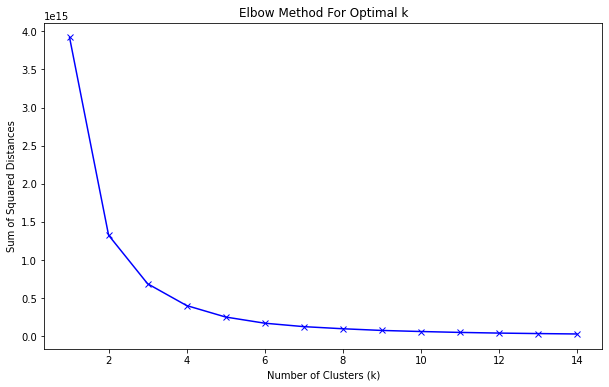

In [144]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming you've already loaded and preprocessed your data as 'X'
features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', "Total_MarkDown"]
X = df_store_dept[features]
# Use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster center
sum_of_squared_distances = []

K = range(1,15)  # here we're checking for up to 14 clusters
for k in K:
    km = KMeans(n_clusters=k, n_init=10)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)

# Plot the elbow
plt.figure(figsize=(10,6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

For n_clusters = 2, the silhouette score is 0.755
For n_clusters = 3, the silhouette score is 0.683
For n_clusters = 4, the silhouette score is 0.664
For n_clusters = 5, the silhouette score is 0.651
For n_clusters = 6, the silhouette score is 0.637
For n_clusters = 7, the silhouette score is 0.614
For n_clusters = 8, the silhouette score is 0.608
For n_clusters = 9, the silhouette score is 0.603
For n_clusters = 10, the silhouette score is 0.603


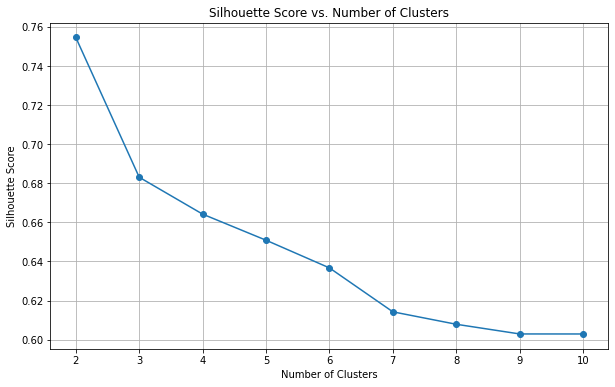

In [145]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming you've already loaded and preprocessed your data as 'X'

# Determine the range of cluster numbers you want to test (e.g., 2 to 10)
range_n_clusters = list(range(2,11))

silhouette_scores = []

# Calculate silhouette scores for different numbers of clusters
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(X)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10,6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.grid(True)
plt.show()

In [146]:
sum_of_squared_distances

[3918670303169708.0,
 1325994215817703.8,
 689252373275130.5,
 403252707834513.7,
 252887202383686.72,
 172083323373792.38,
 127023234685149.75,
 99218492322815.08,
 77012225832647.78,
 63017265508120.4,
 51197522893821.17,
 42363587681243.77,
 36069408765720.875,
 30678416164753.03]

In [147]:
silhouette_scores

[0.7545858723319415,
 0.6830845251807299,
 0.6642110362366702,
 0.6508685730785952,
 0.6367054134341825,
 0.6142362253715588,
 0.6078714353580262,
 0.6029215443121192,
 0.6029083500861345]

In [148]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecting relevant columns and scaling the data
features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', "Total_MarkDown"]
X = df_store_dept[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_scaled)
df_store_dept['Cluster'] = kmeans.labels_

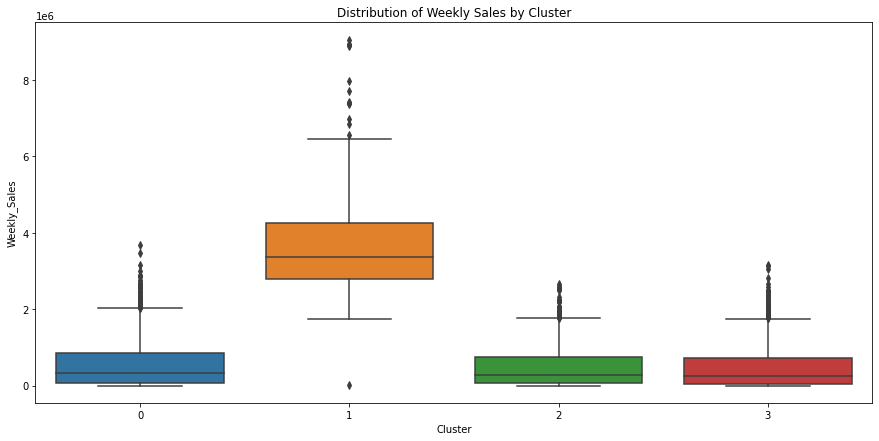

In [149]:
# Visualization for the distribution of Weekly Sales across clusters
plt.figure(figsize=(15, 7))
sns.boxplot(x='Cluster', y='Weekly_Sales', data=df_store_dept)
plt.title('Distribution of Weekly Sales by Cluster')
plt.show()

In [150]:
print(df_store_dept[df_store_dept["Cluster"] == 0]["Dept"].unique())
print(df_store_dept[df_store_dept["Cluster"] == 1]["Dept"].unique())
print(df_store_dept[df_store_dept["Cluster"] == 2]["Dept"].unique())
print(df_store_dept[df_store_dept["Cluster"] == 3]["Dept"].unique())

[ 1  3  4  6 10 11 12 14 16 17 18 19 20 21 22 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 41 42 44 45 47 48 49 50 52 54 55 56 58 59 60 67 71 74 79
 80 81 82 83 85 87 90 91 93 94 96 97 98  5  7  8  9 13 23 38 40 46 72 77
 78 92 95 99 51  2 39 65]
[38 40 72 87 90 91 92 93 94 95  2  4  8 13  5  7 10 23 46 79 96 97  9 77
  1 80 81 82]
[77 78  1  3  6  9 11 12 14 16 17 18 19 20 21 22 24 25 26 27 28 29 30 31
 32 33 34 35 36 37 41 42 44 45 47 48 49 52 54 55 56 58 59 60 67 71 74 80
 81 82 83 85 87 98 99  2  4  5  7  8 10 13 23 38 40 46 72 79 90 91 92 93
 94 95 96 97 43 50 51 39]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 41 42 44 45 46 47 48 49 52 54 55 56
 58 59 60 67 71 74 77 79 80 81 82 83 85 96 97 98 99 87 40 51 72 90 91 92
 94 95 38 78 93]


In [151]:
print(df_store_dept[df_store_dept["Cluster"] == 0]["Dept"].nunique())
print(df_store_dept[df_store_dept["Cluster"] == 1]["Dept"].nunique())
print(df_store_dept[df_store_dept["Cluster"] == 2]["Dept"].nunique())
print(df_store_dept[df_store_dept["Cluster"] == 3]["Dept"].nunique())

80
28
80
77


In [152]:
df_store_dept["Dept"].nunique()

81

In [153]:
print(df_store_dept[df_store_dept["Cluster"] == 0]["Store"].unique())
print(df_store_dept[df_store_dept["Cluster"] == 1]["Store"].unique())
print(df_store_dept[df_store_dept["Cluster"] == 2]["Store"].unique())
print(df_store_dept[df_store_dept["Cluster"] == 3]["Store"].unique())

[10 12 14 15 18 19 22 24 27 28 29 33 34 35 38 42 45]
[ 1  2  3  4  6  8  9 10 11 12 13 14 17 18 19 20 22 23 24 25 26 27 28 31
 32 34 35 37 39 40 41 42 43 45]
[ 2  4  7  8  9 13 14 15 16 17 18 19 20 21 22 23 25 26 27 29 30 31 32 33
 34 35 40 41 42 44 45]
[ 1  2  3  4  5  6  7  8  9 11 16 21 25 30 31 32 34 36 37 39 41 43 44]


In [154]:
print(df_store_dept[df_store_dept["Cluster"] == 0]["Store"].nunique())
print(df_store_dept[df_store_dept["Cluster"] == 1]["Store"].nunique())
print(df_store_dept[df_store_dept["Cluster"] == 2]["Store"].nunique())
print(df_store_dept[df_store_dept["Cluster"] == 3]["Store"].nunique())

17
34
31
23


In [155]:
df_store_dept["Store"].nunique()

45

In [156]:
cluster_summary = df_store_dept.groupby('Cluster')[features].mean().reset_index()

In [157]:
cluster_summary

,Cluster,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Total_MarkDown
0,0,5.657014e+05,60.667614,3.835863,141.572420,8.940538,19519.141740
1,1,3.725462e+06,59.868795,3.641099,176.674291,7.033920,25563.219155
2,2,4.828556e+05,49.161666,3.606190,166.081228,6.347149,19325.055515
3,3,4.860914e+05,68.010749,3.491424,221.112942,6.733450,15247.300424


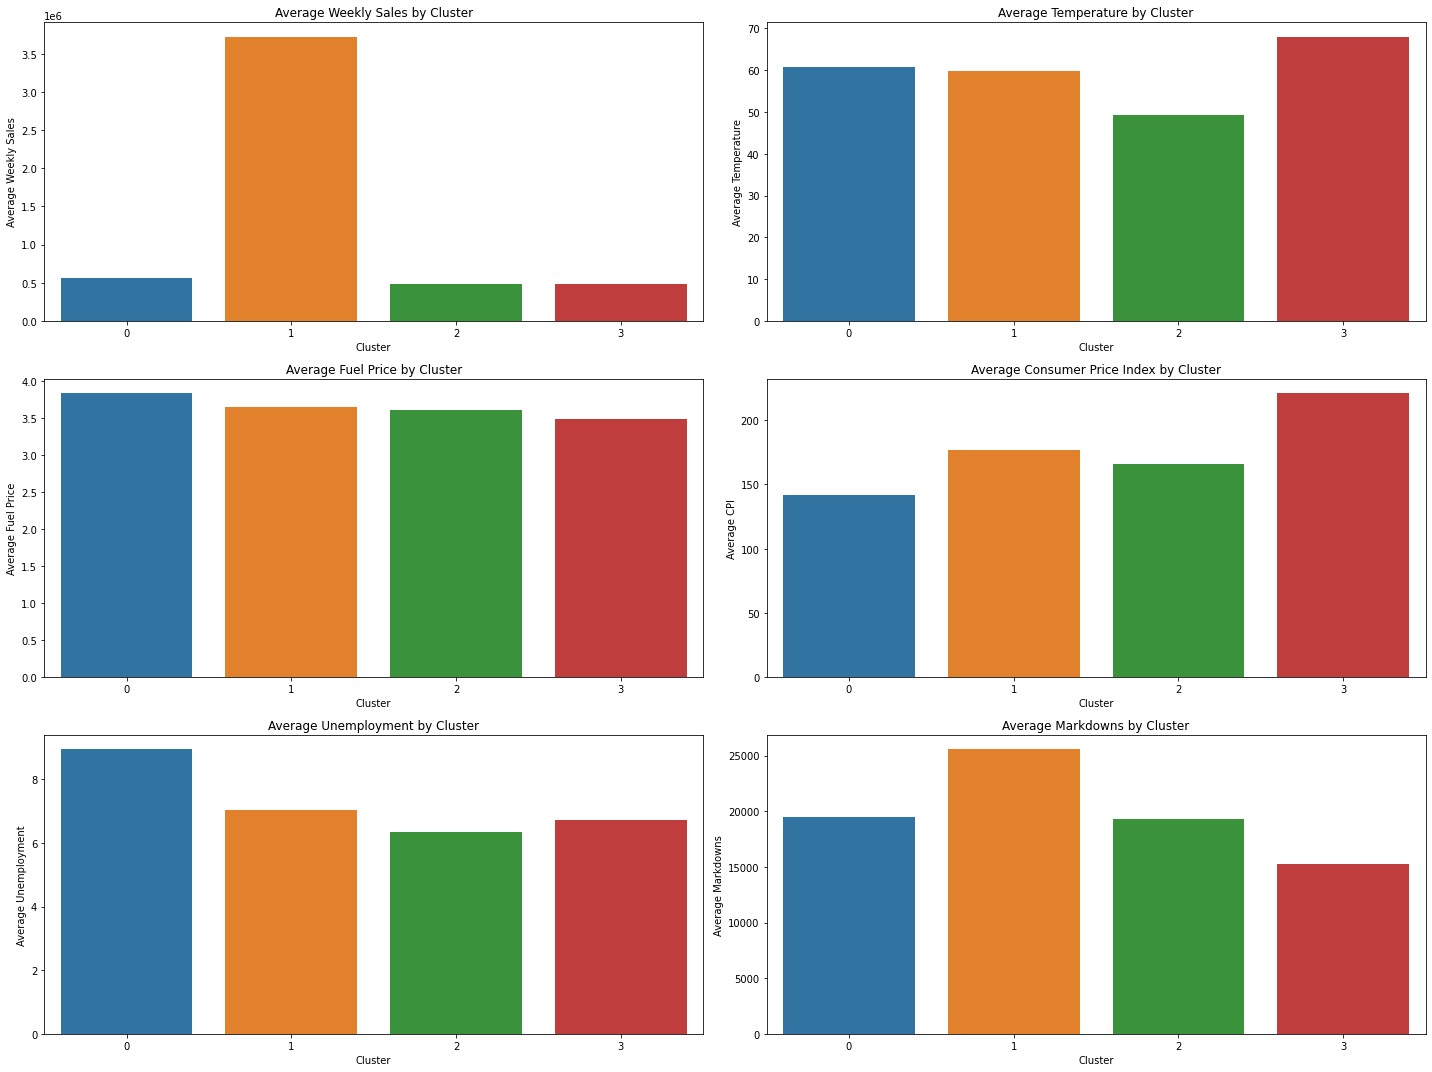

In [158]:
# Create a list of the features to be plotted along with their respective titles and y-labels
features = [
    ('Weekly_Sales', 'Average Weekly Sales by Cluster', 'Average Weekly Sales'),
    ('Temperature', 'Average Temperature by Cluster', 'Average Temperature'),
    ('Fuel_Price', 'Average Fuel Price by Cluster', 'Average Fuel Price'),
    ('CPI', 'Average Consumer Price Index by Cluster', 'Average CPI'),
    ('Unemployment', 'Average Unemployment by Cluster', 'Average Unemployment'), 
    ("Total_MarkDown", 'Average Markdowns by Cluster', 'Average Markdowns')
]

plt.figure(figsize=(20, 15))

# Loop through the features list and plot each feature in a subplot
for i, (feature, title, ylabel) in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.barplot(x='Cluster', y=feature, data=cluster_summary)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Cluster')

plt.tight_layout()
plt.show()

In [159]:
def diagnostic_tests(y, X, model):
    results = {}

    # Breusch-Pagan Test for Homoscedasticity
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    results['Breusch-Pagan p-value'] = bp_test[1]

    # Anderson-Darling Test for Normality
    a_test = anderson(model.resid)
    results['Anderson-Darling Statistic'] = a_test.statistic
    results['Anderson-Darling 5% Critical Value'] = a_test.critical_values[2]

    # VIF for Multicollinearity
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    results['Max VIF'] = vif_data['VIF'].max()

    # Durbin-Watson for Autocorrelation
    results['Durbin-Watson Statistic'] = sm.stats.durbin_watson(model.resid)

    return results

In [160]:
diagnostics = {}

predictors = ['Total_MarkDown', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
X = sm.add_constant(train_df[predictors])
y = train_df['Weekly_Sales']

model = sm.OLS(y, X).fit()

# Diagnostic tests
diagnostics["result"] = diagnostic_tests(y, X, model)

diagnostics_df = pd.DataFrame(diagnostics).T
diagnostics_df.head()

,Anderson-Darling 5% Critical Value,Anderson-Darling Statistic,Breusch-Pagan p-value,Durbin-Watson Statistic,Max VIF
result,0.787,36628.914285,2.559888e-169,0.114456,131.47741


1. **Anderson-Darling Test for Normality**:
    - **5% Critical Value**: 0.787
    - **Anderson-Darling Statistic**: 36628.914285
  
   The Anderson-Darling test is a test of goodness-of-fit, particularly suited for checking if a given sample follows a particular distribution (like a normal distribution). If the Anderson-Darling Statistic is greater than the critical value, then the sample doesn't follow the distribution under test (at the given significance level). In your case, the statistic is much greater than the 5% critical value, indicating that the data does not follow a normal distribution.

2. **Breusch-Pagan Test for Homoscedasticity**:
    - **Breusch-Pagan p-value**: 2.559888e-169
  
   This test checks the assumption of constant variance (homoscedasticity). A low p-value indicates the presence of heteroscedasticity (non-constant variance). Given the extremely low p-value you provided, there is strong evidence to reject the null hypothesis of constant variance. Thus, your data appears to be heteroscedastic.

3. **Durbin-Watson Test for Autocorrelation**:
    - **Durbin-Watson Statistic**: 0.114456
  
   The Durbin-Watson test is used to detect the presence of autocorrelation (a relationship between values separated from each other by a given time lag) in the residuals of a regression analysis. The statistic ranges from 0 to 4, with a value of 2 suggesting no autocorrelation. A value below 2 suggests positive autocorrelation, and above 2 suggests negative autocorrelation. Your statistic of 0.114456 is far below 2, indicating strong positive autocorrelation in the residuals.

4. **Variance Inflation Factor (VIF)**:
    - **Max VIF**: 131.47741
  
   VIF is a metric used to detect multicollinearity in regression. A rule of thumb is that if the VIF is above 5-10, then multicollinearity is high, indicating that some predictors are correlated with other predictors. The VIF value you provided is 131.47741, which is significantly above the common threshold, suggesting that multicollinearity is indeed present in your data.

In summary, based on the diagnostic results:
- Data is not normally distributed.
- There is evidence of heteroscedasticity.
- The residuals from your regression have strong positive autocorrelation.
- There's significant multicollinearity among some of your predictors.